# 为了得到一个领域内的模型

分为几个步骤。

1. 整理数据集；
2. 训练模型；
3. 使用训练好的模型来推理

## 整理数据集

我们参考[文本识别](https://paddlepaddle.github.io/PaddleOCR/latest/ppocr/model_train/recognition.html#13)这个站点来构建模型。

如果使用多语言模型训练数据集，需要过滤掉部分我们不需要的数据，例如非数字的数据。

我把数据存储到`meter_extra`目录下了。

### 开源合成工具 text_renderer

工具的网址是： https://github.com/Sanster/text_renderer。 我们目前没有使用这个工具。

- 我们没有采用lmdb格式的数据集


### 使用 ICDAR2015 数据集

- 没有使用。应该也需要过滤数字文件。

### 查看我们自己的数据集

1. 我们用的是真实图片
2. 用的是full-meter-reading area
3. train shape `32,300,3`; test and valid shape `32,192,3`

In [1]:
import os
import pathlib
from matplotlib import pyplot as plt

In [2]:

dataset = pathlib.Path('./train_data')
print(os.listdir(dataset / 'rec'))

def preview_dataset(filename):
  file = dataset / 'rec' / filename

  with open(file, 'r') as f:
    lines = f.readlines()[:3]
    print(lines)

  return lines

lines = preview_dataset('train_list.txt')
test_lines = preview_dataset('test.list')
val_lines = preview_dataset('valid.list')

['train_list.txt', 'valid', 'test.list', 'train', 'valid.list', 'test']
['rec/train/000000.png\t000828\n', 'rec/train/000001.png\t000917\n', 'rec/train/000002.png\t001857\n']
['rec/test/000000.png\t004829\n', 'rec/test/000001.png\t521090\n', 'rec/test/000002.png\t001110\n']
['rec/valid/000000.png\t001721\n', 'rec/valid/000001.png\t002685\n', 'rec/valid/000002.png\t000895\n']


[['rec/train/000000.png', '000828\n'], ['rec/train/000001.png', '000917\n'], ['rec/train/000002.png', '001857\n']]
3
[(32, 300, 3), (32, 300, 3), (32, 300, 3)]


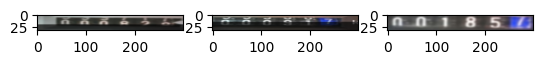

[['rec/test/000000.png', '004829\n'], ['rec/test/000001.png', '521090\n'], ['rec/test/000002.png', '001110\n']]
3
[(32, 192, 3), (32, 192, 3), (32, 192, 3)]


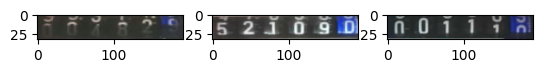

[['rec/valid/000000.png', '001721\n'], ['rec/valid/000001.png', '002685\n'], ['rec/valid/000002.png', '000895\n']]
3
[(32, 192, 3), (32, 192, 3), (32, 192, 3)]


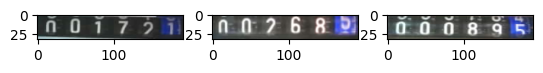

In [3]:
# 查看图片

def preview_img(lines):
  img_and_labels = [line.split('\t') for line in lines]
  print(img_and_labels)
  images = [plt.imread(dataset / il[0]) for il in img_and_labels]
  print(len(images))
  print([img.shape for img in images])

  plt.subplot(1, 3, 1)
  plt.imshow(images[0])
  plt.subplot(1, 3, 2)
  plt.imshow(images[1])
  plt.subplot(1, 3, 3)
  plt.imshow(images[2])
  plt.show()

preview_img(lines)
preview_img(test_lines)
preview_img(val_lines)

## 训练模型

通过上一步情况来看，我们数据集已经整理好了。下一步，我们使用这些数据进行训练。

这是原本`train_meter_v3.sh`的版本。

### config 文件

In [2]:
import pathlib
config_file = pathlib.Path('./atrain_script/configs/ch_PP-OCRv3_rec_distillation.yml')
print(config_file.read_text())

Global:
  debug: false
  use_gpu: true
  epoch_num: 800
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: ./output/rec_ppocr_v3_distillation_meter
  save_epoch_step: 3
  eval_batch_step: 500
  cal_metric_during_train: true
  pretrained_model:
  checkpoints:
  save_inference_dir:
  use_visualdl: false
  infer_img: doc/imgs_words/ch/word_1.jpg
  character_dict_path: atrain_script/meter_dict.txt
  # character_dict_path: ./atrain_script/meter_dict.txt # seems not work.
  max_text_length: &max_text_length 8
  infer_mode: false
  use_space_char: false
  distributed: true
  save_res_path: ./output/rec/predicts_ppocrv3_distillation_meter.txt
  d2s_train_image_shape: [3, 32, 300]
  use_wandb: True

wandb:  
  project: ProjectMeter  # (optional) this is the wandb project name

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Piecewise
    decay_epochs : [700]
    values : [0.0005, 0.00005]
    warmup_epoch: 5
  regularizer:
    name: L2
    factor: 3.0e-05


Arc

引入 wandb 来看训练过程中的数据

In [4]:
!pip install wandb
!git config --global --add safe.directory /opt/PaddleOCR

import wandb
wandb.login()



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


True

In [5]:
# skip this method.

# !python -m paddle.distributed.launch --gpus '4,5,6,7' \
#                        tools/train.py -c ./atrain_script/configs/ch_PP-OCRv3_rec_distillation.yml \
#                        -o Global.epoch_num=20 \
#                        Global.eval_batch_step='[1000, 2000]' \
#                        Train.dataset.data_dir=./train_data \
#                        Train.dataset.label_file_list=['./train_data/rec/train_list.txt'] \
#                        Train.loader.batch_size_per_card=64 \
#                        Eval.dataset.data_dir=./train_data \
#                        Eval.dataset.label_file_list=["./train_data/rec/valid.list"] \
#                        Eval.loader.batch_size_per_card=64

### 尝试用 pretrain 的模型来做训练

- 已知问题：会覆盖之前的版本
- 现在使用还不是合适的 dict，用的是`ppocr/utils/ppocr_keys_v1.txt`

In [6]:
# validation at first and end of epoch.
!python -m paddle.distributed.launch --gpus '4,5,6,7' \
                       tools/train.py -c ./atrain_script/configs/ch_PP-OCRv3_rec_distillation.yml \
                       -o Global.pretrained_model=./ckpt/ch_PP-OCRv3_rec_train/best_accuracy \
                       Global.epoch_num=20 \
                       Global.eval_batch_step='[1000, 2000]' \
                       Train.dataset.data_dir=./train_data \
                       Train.dataset.label_file_list=['./train_data/rec/train_list.txt'] \
                       Train.loader.batch_size_per_card=64 \
                       Eval.dataset.data_dir=./train_data \
                       Eval.dataset.label_file_list=["./train_data/rec/valid.list"] \
                       Eval.loader.batch_size_per_card=64

LAUNCH INFO 2025-02-14 21:16:49,068 -----------  Configuration  ----------------------
LAUNCH INFO 2025-02-14 21:16:49,068 devices: 4,5,6,7
LAUNCH INFO 2025-02-14 21:16:49,068 elastic_level: -1
LAUNCH INFO 2025-02-14 21:16:49,068 elastic_timeout: 30
LAUNCH INFO 2025-02-14 21:16:49,068 gloo_port: 6767
LAUNCH INFO 2025-02-14 21:16:49,068 host: None
LAUNCH INFO 2025-02-14 21:16:49,068 ips: None
LAUNCH INFO 2025-02-14 21:16:49,068 job_id: default
LAUNCH INFO 2025-02-14 21:16:49,068 legacy: False
LAUNCH INFO 2025-02-14 21:16:49,068 log_dir: log
LAUNCH INFO 2025-02-14 21:16:49,068 log_level: INFO
LAUNCH INFO 2025-02-14 21:16:49,068 master: None
LAUNCH INFO 2025-02-14 21:16:49,068 max_restart: 3
LAUNCH INFO 2025-02-14 21:16:49,068 nnodes: 1
LAUNCH INFO 2025-02-14 21:16:49,068 nproc_per_node: None
LAUNCH INFO 2025-02-14 21:16:49,068 rank: -1
LAUNCH INFO 2025-02-14 21:16:49,068 run_mode: collective
LAUNCH INFO 2025-02-14 21:16:49,068 server_num: None
LAUNCH INFO 2025-02-14 21:16:49,068 servers:

## 推理模型

- 新模型的存储位置是：`output/rec_ppocr_v3_distillation_meter/best_model`.
- 加载模型后，可以获得更好的性能
- 加载保存的最佳模型
- 查看 FPS

使用 paddlex + pipeline 加载最优的模型

### 模型开发过程中进行 predict

In [9]:
# 预测英文结果
!python3 tools/infer_rec.py \
  -c atrain_script/configs/ch_PP-OCRv3_rec_distillation.yml \
  -o Global.pretrained_model=output/rec_ppocr_v3_distillation_meter/best_accuracy \
     Global.infer_img=atrain_script/images/cropped2.jpg

wandb: Currently logged in as: svtter (svtter-xiu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6wandb: \ Waiting for wandb.init()...
wandb: Run data is saved locally in ./output/rec_ppocr_v3_distillation_meter/wandb/run-20250214_212148-qb21zoin
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run spellbinding-dove-18
wandb: ⭐️ View project at https://wandb.ai/svtter-xiu/ProjectMeter
wandb: 🚀 View run at https://wandb.ai/svtter-xiu/ProjectMeter/runs/qb21zoin
[2025/02/14 21:21:50] ppocr INFO: Architecture : 
[2025/02/14 21:21:50] ppocr INFO:     Models : 
[2025/02/14 21:21:50] ppocr INFO:         Student : 
[2025/02/14 21:21:50] ppocr INFO:             Backbone : 
[2025/02/14 21:21:50] ppocr INFO:                 last_conv_stride : [1, 2]
[2025/02/14 21:21:50] ppocr INFO:                 last_poo

### 转换成推理模型

只有转换成高性能模型，才能更好的部署到服务器上。

- 为了把现在这个表现很好的模型转换成可以用于推理的模型，执行以下的代码。
- 这个推理模型无法直接使用 http，因此不建议使用

In [10]:
# 新 IR 模型
import os
os.environ['FLAGS_enable_pir_api']='1'

!python3 tools/export_model.py \
   -c atrain_script/configs/ch_PP-OCRv3_rec_distillation.yml \
   -o Global.pretrained_model=./output/rec_ppocr_v3_distillation_meter/best_accuracy \
   Global.save_inference_dir=./inference/en_PP-OCRv3_rec/

W0214 21:58:21.532662  2378 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 6.0, Driver API Version: 12.3, Runtime API Version: 11.2
W0214 21:58:21.535908  2378 gpu_resources.cc:91] device: 0, cuDNN Version: 8.1.
[2025/02/14 21:58:23] ppocr INFO: load pretrain successful from ./output/rec_ppocr_v3_distillation_meter/best_accuracy
[2025/02/14 21:58:25] ppocr INFO: inference model is saved to ./inference/en_PP-OCRv3_rec/Teacher/inference
[2025/02/14 21:58:26] ppocr INFO: inference model is saved to ./inference/en_PP-OCRv3_rec/Student/inference
[2025/02/14 21:58:26] ppocr INFO: Export inference config file to ./inference/en_PP-OCRv3_rec/inference.yml


#### 使用 pdserving 进行推理

- 这是采用另外一种方法进行转换；在上一个转换的基础上，生成新的
- 使用 paddle serving，又名 pdserving 进行部署

In [1]:
# 切换目录
import os

project_root = os.getcwd()
print(project_root)
os.chdir('./deploy/pdserving/')

!ls

/opt/PaddleOCR
README.md		  imgs			   serving_client_conf.prototxt
README_CN.md		  ocr_cpp_client.py	   web_service.py
__init__.py		  ocr_reader.py		   web_service_det.py
config.yml		  pipeline_http_client.py  web_service_rec.py
general_detection_op.cpp  pipeline_rpc_client.py   win


In [1]:
# install depends

# 安装serving，用于启动服务
!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_server_gpu-0.8.3.post102-py3-none-any.whl
!pip3 install paddle_serving_server_gpu-0.8.3.post102-py3-none-any.whl
# 如果是cuda10.1环境，可以使用下面的命令安装paddle-serving-server
# wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_server_gpu-0.8.3.post101-py3-none-any.whl
# pip3 install paddle_serving_server_gpu-0.8.3.post101-py3-none-any.whl

# 安装client，用于向服务发送请求
!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_client-0.8.3-cp37-none-any.whl
!pip3 install paddle_serving_client-0.8.3-cp37-none-any.whl

# 安装serving-app
!wget https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_app-0.8.3-py3-none-any.whl
!pip3 install paddle_serving_app-0.8.3-py3-none-any.whl

--2025-02-15 12:07:17--  https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_server_gpu-0.8.3.post102-py3-none-any.whl
Resolving paddle-serving.bj.bcebos.com (paddle-serving.bj.bcebos.com)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘paddle-serving.bj.bcebos.com’
Processing ./paddle_serving_server_gpu-0.8.3.post102-py3-none-any.whl
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/PaddleOCR/paddle_serving_server_gpu-0.8.3.post102-py3-none-any.whl'

--2025-02-15 12:07:30--  https://paddle-serving.bj.bcebos.com/test-dev/whl/paddle_serving_client-0.8.3-cp37-none-any.whl
Resolving paddle-serving.bj.bcebos.com (paddle-serving.bj.bcebos.com)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘paddle-serving.bj.bcebos.com’
ERROR: paddle_serving_client-0.8.3-cp37-none-any.whl is not a supported wheel on this platform.
--2025-02-15 12:07:42--  https://paddle-se

In [2]:
# 转换识别模型
!python3 -m paddle_serving_client.convert --dirname /opt/PaddleOCR/inference/en_PP-OCRv3_rec/Student \
                                         --model_filename inference.pdmodel          \
                                         --params_filename inference.pdiparams       \
                                         --serving_server ./ppocr_rec_v3_serving/  \
                                         --serving_client ./ppocr_rec_v3_client/

/usr/bin/python3: Error while finding module specification for 'paddle_serving_client.convert' (ModuleNotFoundError: No module named 'paddle_serving_client')


In [2]:
from paddleocr import PaddleOCR

In [9]:
ocr = PaddleOCR(
    rec_model_dir='output/rec_ppocr_v3_distillation_meter',
    rec_char_dict_path='ppocr/utils/ppocr_keys_v1.txt',  # 使用训练时相同的字典文件
    use_gpu=True,
    use_angle_cls=False,  # 如果不需要方向分类，可以关闭
    det=False  # 如果只需要识别功能，可以关闭检测
)

download https://paddleocr.bj.bcebos.com/PP-OCRv4/chinese/ch_PP-OCRv4_rec_infer.tar to output/rec_ppocr_v3_distillation_meter/ch_PP-OCRv4_rec_infer.tar


100%|██████████| 10720/10720 [00:10<00:00, 978.92it/s] 

[2025/02/14 15:00:04] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=False, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv4_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2

[2025/02/14 15:00:05] ppocr WARNING: The first GPU is used for inference by default, GPU ID: 0


In [7]:
img_path = 'atrain_script/images/crop3.jpg'
result = ocr.ocr(img_path, cls=False, det=False)

In [8]:
print(result)

[[('nlola151710', 0.6983380913734436)]]
